In [186]:
class server:
     def __init__(self):
            self.party_means = []
     def receive_parties(self,parties):
        self.parties = parties
        self.num_parties = len(parties)
     def receive_mean(self,mean):
        self.party_means.append(mean)
        if len(self.party_means) ==  self.num_parties:
            distances = self.party_means
            distances= list(np.concatenate((distances),axis=0))
            mean = list(np.mean(distances,axis=0))
            for p in parties:
                p.receive_mean(mean)



In [191]:
import csv
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance
from collections import Counter
from sklearn.linear_model import LinearRegression
import math
import itertools

class vfl_party:
    def __init__(self,data,y,k,p_id,server):
            self.data = data.transpose()
            self.server = server
            self.k = k
            self.data = data
            self.y = y
            self.model = LinearRegression()
            self.cluster_means = np.tile([list(np.linspace(0, 1, k))],(self.data.shape[0],1)).T
            self.p_id = p_id
            n = self.data.shape[1]
            self.beta = n**(1/np.sqrt(n))


    def receive_mean(self, mean):
        self.cluster_means = [mean]*self.data.shape[1]
        return
    def generate_cluster_means_vfl(self,gamma_n, gamma_d, num_loops,checkpoint,true_shap,n):
        distances = []
        for i in range(len(self.data[0])):
            dist= []
            for j in range(len(self.cluster_means)):
                d = distance.euclidean(self.data[:,i],self.cluster_means[j])/X.shape[1]
                
                dist.append(d)
            distances.append(dist)
        serv.receive_mean(distances)    
    
    def divisive_shap_approx_knn(self,X, y, model, beta, gamma_n, gamma_d,k, num_loops,checkpoint,it):
        
        if X.shape[1] > max(np.emath.logn(beta, n), k):

            
                if it ==1:
                    it+=1
                    #parition according to clusters 

                    distances = []

                    for i in range(X.shape[1]):
                        dist= []

                        for j in range(self.k):
                            
                            d = abs(np.mean(X[:,i])-self.cluster_means[0][j])
                            
                            dist.append(d)
                        distances.append(dist)  
                    clusters = np.argmin(distances,axis=1)
                    
                    df = pd.DataFrame(X[:,clusters==1])
                    results = []
                    for cluster_idx in range(self.k):
                        results.append(self.divisive_shap_approx_knn(X[:,clusters==cluster_idx],y,model,beta,gamma_n,gamma_d,k,num_loops,False,it))
                    return self.union(results)    
                        
                        
                    #assign clusters and divide the data
                else:
                    partitions = []
                    sum_gamma_n = 0
                    sum_gamma_d = 0
                    for _ in range(num_loops):
                        split_S = self.partition_knn(X,y,k)
                        partitions.append(split_S)
                        sum_gamma_n += self.value(X, y, model)
                        sum_gamma_d += sum([self.value(Xi, yi, model) for Xi, yi in split_S])
                    gamma_n = gamma_n * (sum_gamma_n / num_loops)
                    gamma_d = gamma_d * (sum_gamma_d / num_loops)
                    res=self.union([self.divisive_shap_approx_knn(Xi,
                                                       yi,
                                                       model,
                                                       beta,
                                                       gamma_n,
                                                       gamma_d,
                                                       k,
                                                       num_loops,False,it) for Xi, yi in split_S])

                    return res

        else:
            
            shap = self.shapley_true(X, y, model)
            shap = shap*gamma_n/gamma_d
            return (X, y, shap)
    def allign_parties(self,num_loops = 1):
       """allign parties using cluster means"""
       self.generate_cluster_means_vfl(1, 1, num_loops,False,[],self.data.shape[1])
       return
    def main(self,num_loops = 1): 
        X2, y2, shap = self.divisive_shap_approx_knn(self.data, self.y, self.model, self.beta, 1, 1,self.k, num_loops,False,1)
        w = sum(shap)
        vN = self.value(X, y, self.model)
        if w != vN:
            if w == 0:
                shap = np.array([vN/X.shape[1]]*X.shape[1])
            gamma = vN/w
            shap = shap*gamma
            
        self.shap = shap    
        return (X2, y2, shap)
    def shapley_true(self,X, y, model):
        """Returns true shapley value of each feature (numpy array)"""
        N = X.shape[1]
        shap = np.zeros(N)
        for i in range(N):
            other_features = set(range(N))
            other_features.remove(i)
            subsets = [subset for j in range(N) for subset in self.findsubsets(other_features, j)]
            for subset in subsets:
                coeff = math.factorial(len(subset))*math.factorial(N - len(subset) - 1)/math.factorial(N)
                shap[i] += coeff*(self.value(X[:,list(subset) + [i]], y, model)-self.value(X[:, list(subset)], y, model))
        return np.array(shap)
    def findsubsets(self,s, n):
        return list(itertools.combinations(s, n))

    def value(self,X, y, model):
        if X.size == 0:
            return 0
        else:
            reg = model.fit(X, y)
            return reg.score(X, y)
    def partition_knn(self,X,y,k):
        """Partitions data according to K nearest neighbors"""
        transposed_X = X.T

        kmeans = KMeans(
            init="random",
            n_clusters=k,
            n_init=10,
            max_iter=300,
            #random_state=42
        )
        kmeans.fit(transposed_X)
        labels = kmeans.labels_
        X = transposed_X.T
        partitions = []
        X = pd.DataFrame(X)
        for i in range(k):
            partitions.append((np.array(X.iloc[:,labels == i]),y))

        return partitions
    def union(self,S_split):
        """Returns the union of several sets (Xi, Yi, Shapi)"""
        
        X = S_split[0][0]
        
        y = S_split[0][1]
        shap = S_split[0][2]
        for Xi, _, shapi in S_split[1:]:
            X = np.concatenate((X, Xi), axis=1)
            shap = np.concatenate((shap, shapi))   
        return (X, y, shap)
    def get_shapley_values(self):
        return self.shap

In [182]:
from sklearn.preprocessing import MinMaxScaler
#import dataset
df = pd.read_csv("./FIFA 2018 Statistics.csv")
feature_names = [i for i in df.columns if df[i].dtype in [np.int64, np.int64]]
X = df[feature_names]
X = MinMaxScaler().fit_transform(X)
y = (df['Man of the Match'] == "Yes")
y = [1 if label == True else 0 for label in y]

num_parties = 2
n = X.shape[1]//num_parties

k = 2

serv= server(0)
parties = []

# Split the data into two parts
for i in range(num_parties):
 parties.append(vfl_party(X[:,i:i+n],y, k, i,serv))
serv.receive_parties(parties)

for p in parties:
 p.allign_parties()
for p in parties:
 p.main()
shap_values = []
for p in parties:
  shap_values.extend(p.get_shapley_values())
print(shap_values)

[array([0.18355766, 0.50486318]), array([0.34030306, 0.3404844 ]), array([0.29854134, 0.39320823]), array([0.23583862, 0.43927843]), array([0.30807046, 0.39027531]), array([0.25927249, 0.4436799 ]), array([0.30345089, 0.38496644]), array([0.22553092, 0.4833014 ]), array([0.32782891, 0.36110869]), array([0.34030306, 0.3404844 ]), array([0.29854134, 0.39320823]), array([0.23583862, 0.43927843]), array([0.30807046, 0.39027531]), array([0.25927249, 0.4436799 ]), array([0.30345089, 0.38496644]), array([0.22553092, 0.4833014 ]), array([0.32782891, 0.36110869]), array([0.23787468, 0.46073538])]
[0.2788392071204452, 0.41323356433550334]
[0.2548060361963119, 0.05198657704821551, 0.003107383418446498, 0.0007762489736410767, 0.014650554174186568, 0.012568995343898614, 0.00774701452222197, 0.003923000924600017, 0.01503238555927046, 0.001704028582218041, 0.0029146738913014385, 0.225551546643149, 0.018981046610362325, 0.008399145296882063, 0.032184338698298294, 0.026910220047934915, 0.01658635871869

In [183]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

true_shapley = [0.16999648, 0.00351305, 0.01231289, 0.03640622, 0.0052994,  0.02015739, 0.01889732, 0.0034261,  0.00753081, 0.00282818, 0.00419999, 0.00374287, 0.00380925, 0.00176043, 0.01024351, 0.00525661, 0.01237468, 0.01605793]
mse = mean_squared_error(true_shapley, shap_values)
rmse = np.sqrt(mse)
print(rmse)


0.058642560357480535


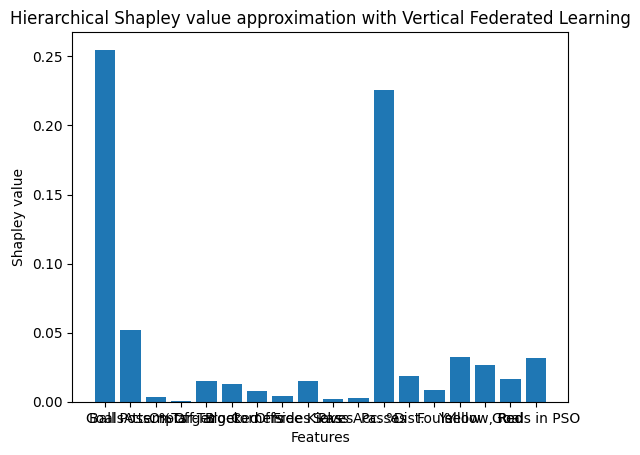

In [184]:
import matplotlib.pyplot as plt
FIFA_cols = ['Goals',	'Ball Poss. %',	'Attempts', 'On-Target',	'Off-Target',	'Blocked',	'Corners',	'Offsides',	'Free Kicks',	'Saves',	'Pass Acc. %',	'Passes',	'Dist.',	'Fouls',	'Yellow',	'Yellow, Red',	'Red'	,'Goals in PSO']
plt.bar(FIFA_cols, shap_values)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('Hierarchical Shapley value approximation with Vertical Federated Learning')
plt.show()

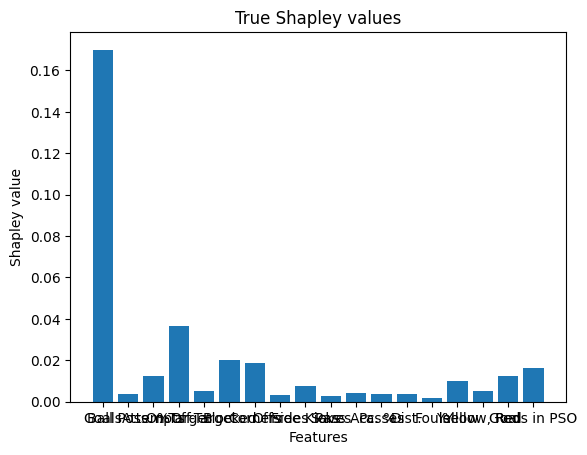

In [160]:
plt.bar(FIFA_cols, true_shapley)
plt.xlabel('Features')
plt.ylabel('Shapley value')
plt.title('True Shapley values')
plt.show()